In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [6]:
y.shape, tx.shape

array([[1.        , 1.94406149],
       [1.        , 0.62753668],
       [1.        , 2.01244346],
       [1.        , 1.39406046],
       [1.        , 0.9134207 ]])

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

### Exercise 1: To understand this data format, answer the following warmup questions:
  * What does each column of  ̃X represent?
     - The first column of X tilde is reserved for the offset term, thus the first column consists only out of 1. All other columns represent one parameter of the ML model respectively.
  * What does each row of  ̃X represent?
    - Each row coresponds to an element of the sample.
  * Why do we have 1’s in  ̃X?
    - For the offset term aka the constant in a linear regression model.
  * If we have heights and weights of 3 people, what would be the size of y and  ̃X? What would  ̃X32 represent?
    - y = weight, xn1 = body height 
    - Shape of y = (3,)
    - Shape of X tilde = (3, 2)
  * In helpers.py, we have already provided code to form arrays for y and  ̃X. Have a look at the code, and make sure you understand how they are constructed.
  * Check if the sizes of the variables make sense (use functions shape).
  * Now we will compute the MSE. Let us introduce the vector notation e = y −  ̃Xw, for given model parameters w = [w0, w1]⊤. Prove that the MSE can also be rewritten in terms of the vector e, as L(w) = ... (4)
  * Complete the implementation of the notebook function compute loss(y, tx, w). You can start by setting w = [1,2]⊤, and test your function

# 1. Computing the Cost Function
Fill in the `compute_cost` function below:

In [14]:


def compute_loss(y, tx, w):

    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # compute prediction error and loss for weights
    predict_error = y - np.dot(tx, w)
    loss = (1/2*tx.shape[0]) * sum(predict_error * predict_error)
    return loss

# test MSE loss function
compute_loss(y, tx, [1,2])

269448336588.7085

# 2. Grid Search

Fill in the function `grid_search()` below:

In [15]:
# from costs import *

def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.
        
    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))

    # compute loss for ever w0, w1 combintation set by the grid
    for i in range(losses.shape[0]): 
        for j in range(losses.shape[1]):
            losses[i, j] = compute_loss(y, tx, [grid_w0[i], grid_w1[j]])

    
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=4242448314.6782527, w0*=66.66666666666669, w1*=16.666666666666686, execution time=0.137 seconds


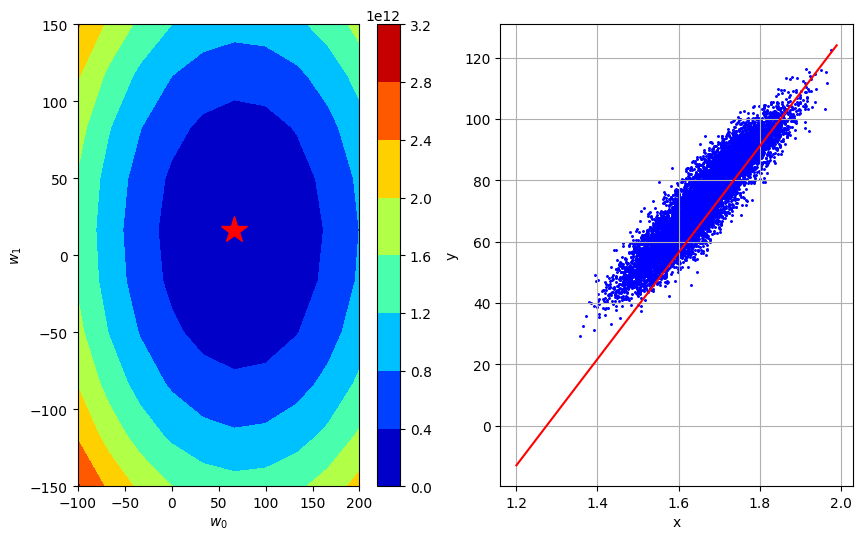

In [16]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

Does this look like a good estimate? Why not? What is the problem? Why is the MSE plot not smooth? Repeat the above exercise by changing the grid spacing to 10 instead of 50. Compare the new fit to the
old one.

To obtain an accurate fit, do you need a coarse grid or a fine grid?
- Try different values of grid spacing. What do you observe?
    - One can observe ...
- How does increasing the number of values affect the computational cost? How fast or slow does your code run?
    - The more dimensions, the slower the computation and thus the higher the computational cost.
    - The finer the grid, the the slower the computation but the better the found weights for the ML model (similar to: computational vs. statisital trade off)

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [19]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # compute partial differentiation of cost function for each weight
    delta_loss_w0 = (- 1 / tx.shape[0]) * sum(y - np.dot(tx, w))
    delta_loss_w1 = (- 1 / tx.shape[0]) * sum((y - np.dot(tx, w)) * tx[:,1])

    # compute gradient of MSE cost function at certain point specified by weights and return it
    return np.array([delta_loss_w0, delta_loss_w1]) # = gradient

# test gradient computation function
print("w0=100, w1=20: ", compute_gradient(y, tx, np.array([100, 20])))
print("w0=50, w1=10: ", compute_gradient(y, tx, np.array([50, 10])))

w0=100, w1=20:  [26.706078    6.52028757]
w0=50, w1=10:  [-23.293922    -3.47971243]


Please fill in the functions `gradient_descent` below:

In [ ]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD 
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute gradient and loss
        # ***************************************************
        raise NotImplementedError
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by gradient
        # ***************************************************
        raise NotImplementedError
        
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [ ]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses, gd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# 4. Stochastic gradient descent

In [ ]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from just few examples n and their corresponding y_n labels.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: implement stochastic gradient computation. It's the same as the usual gradient.
    # ***************************************************
    raise NotImplementedError


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).
            
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD 
    """
    
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic gradient descent.
        # ***************************************************
        raise NotImplementedError

        print("SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [ ]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

# 5. Effect of Outliers and MAE Cost Function

In [ ]:
import datetime
from helpers import *

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: reload the data by subsampling first, then by subsampling and adding outliers
# ***************************************************
raise NotImplementedError

x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [ ]:
y.shape, tx.shape

In [ ]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points 
#       and the model fit
# ***************************************************
raise NotImplementedError


end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses, gd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# 6. Subgradient descent

In [ ]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute subgradient gradient vector for MAE
    # ***************************************************
    raise NotImplementedError

In [ ]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD 
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute subgradient and loss
        # ***************************************************
        raise NotImplementedError
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by subgradient
        # ***************************************************
        raise NotImplementedError
        
        ws.append(w)
        losses.append(loss)
        print("SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

In [ ]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(
    y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses, subgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [ ]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic SubGradient Descent algorithm (SubSGD).
            
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD 
    """
    
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):

        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic subgradient descent.
        # ***************************************************
        raise NotImplementedError
        
        print("SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [ ]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses, subsgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))